In [14]:
import numpy as np

import pandas as pd

import sklearn.model_selection as model_selection
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn import linear_model

#convenient for running multiple linear regression with few lines of code
import statsmodels.formula.api as smf


import matplotlib.pyplot as plt
%matplotlib inline

## Import Movie data

In [36]:
data = pd.read_csv("allData.tsv", sep='\t')
data.head()

,userID,age,gender,movieID,name,year,genre1,genre2,genre3,rating
0,747,1,F,1193,One Flew Over the Cuckoo's Nest,1975,Drama,NaN,NaN,5
1,747,1,F,661,James and the Giant Peach,1996,Animation,Children's,Musical,3
2,747,1,F,2804,"Christmas Story, A",1983,Comedy,Drama,NaN,5
3,747,1,F,919,"Wizard of Oz, The",1939,Adventure,Children's,Drama,4
4,747,1,F,2791,Airplane!,1980,Comedy,NaN,NaN,4


In [15]:
df_ratings = pd.read_csv('ratings.csv')
df_ratings.head()

,userID,movieID,rating
0,747,1193,5
1,747,661,3
2,747,2804,5
3,747,919,4
4,747,2791,4


### Collaborative Filtering Implementation

##### There are two approaches

##### 1. Memory based approach: 
This can be divided into two, (i) user-item filtering and (ii) item-item filtering.

In this, we basically calculate the closest the user or item using the Cosine similarity or Pearson correlation coefficients

The cosine similarity for two users is computed as:

$sim(u, u^{'}) = cos(\theta) = \frac{r_u.r_{u^{'}}}{||r_u||||r_{u^{'}}} = \sum_i \frac{r_{ui}r_{u^{'}i}}{\sqrt{\sum_ir_{ui}^2}\sqrt{\sum_ir_{u^{'}i}^2}}$

Here $u$ and $u^{'}$ represents two different users.

We can predict user-u’s rating for movie-i by taking weighted sum of movie-i ratings from all other users (u′s) where weighting is similarity number between each user and user-u.

We now predict a users rating as follows:

#### $\hat{r_{ui}} = \frac{\sum_{u^{'}} sim(u, u^{'})r_{u^{'}i}}{\sum_{u^{'}} |sim(u, u^{'})|}$

Drawback:  its performance decreases when we have sparse data which hinders scalability of this approach for most of the real-world problems.

#### Implementation

Below code creates two new columns for user id and movie id to facilitate the creation of the user item matrix

In [16]:
from itertools import cycle
n_users = df_ratings.userID.unique().shape[0]
n_movies = df_ratings.movieID.unique().shape[0]

l_users = cycle(list(range(n_users)))
l_movies = list(range(n_movies))
df_ratings['user_id'] = df_ratings['userID'].astype("int")
df_ratings['movie_id'] = df_ratings['movieID'].astype("int")
df_ratings['movieID'] = df_ratings['movieID'].astype("int")
#df_ratings['movie_id2'] = df_ratings['movie_id'].astype("str")
current_idm = 1
current_idu = 747
indm = 1
indu = 1
listMID = list(df_ratings["movieID"])
for idx, row in df_ratings.iterrows():
    new_idm = int(df_ratings.loc[idx, 'movieID'])
    #intialize the  foudn movie id in list
    foundm = False
    for k in range(1465):
        if new_idm in listMID:
            #get the index
            lind = listMID.index(new_idm)
            #update the movie_id
            df_ratings.loc[lind, 'movie_id'] = indm
            #now set that list item to zero
            listMID[lind]=0
            foundm = True
        else:
            #break and fetch a new row
            break
    #increment the indicator
    if foundm:
        indm+=1
    #current_idm = new_idm
    
    #there is a bit of logic problem here...
    new_idu = int(df_ratings.loc[idx, 'userID'])
    if new_idu==current_idu:
        df_ratings.loc[idx, 'user_id'] = indu
    else:
        indu+=1
        current_idu = new_idu
        df_ratings.loc[idx, 'user_id'] = indu
        
df_ratings
print(str(n_users) + ' users')
print(str(n_movies) + ' movies')

2353 users
1465 movies


In [17]:
df_ratings.head()

,userID,movieID,rating,user_id,movie_id
0,747,1193,5,1,1
1,747,661,3,1,2
2,747,2804,5,1,3
3,747,919,4,1,4
4,747,2791,4,1,5


In [18]:
## construct a user item matrix
m_ratings = np.zeros((n_users, n_movies))
for row in df_ratings.itertuples():
    #row[3] will be user rating row[4] user_id and row[5] movie_id  
    m_ratings[row[4]-1, row[5]-1] = row[3]

In [19]:
#examine the sparsity of the matrix
sparsity = float(len(m_ratings.nonzero()[0]))
print(sparsity)
sparsity /= (m_ratings.shape[0] * m_ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

31620.0
Sparsity: 0.92%


Split the data into training and test set.

In [20]:
#split into training and testing
def train_test_split(m_ratings):
    test = np.zeros(m_ratings.shape)
    train = m_ratings.copy()
    for user in range(m_ratings.shape[0]):
        #checking for xero ratings
        #confirm with tobias, if user rated less than say k-movies, move to a different pipeline
        if np.count_nonzero(m_ratings[user,:])<20:
            continue
        test_ratings = np.random.choice(m_ratings[user, :].nonzero()[0], size=10, replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = m_ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

Assign the test set to the train handle and the test set to the test handle

In [21]:
train, test = train_test_split(m_ratings)

This module compute the similarity between two user ratings of an item.

In [22]:
#compute the similarity
def fast_similarity(m_ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = m_ratings.dot(m_ratings.T) + epsilon
    elif kind == 'item':
        sim = m_ratings.T.dot(m_ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

Train the model.

In [23]:
#train the model
fast_similarity(train, kind='user')

array([[  1.00000000e+00,   5.89993605e-12,   2.12896795e-01, ...,
          2.42464322e-11,   2.10326586e-01,   3.63696484e-11],
       [  5.89993605e-12,   1.00000000e+00,   1.35656367e-01, ...,
          2.70369035e-11,   1.59908614e-01,   4.05553553e-11],
       [  2.12896795e-01,   1.35656367e-01,   1.00000000e+00, ...,
          2.78747337e-11,   1.57536639e-01,   4.18121005e-11],
       ..., 
       [  2.42464322e-11,   2.70369035e-11,   2.78747337e-11, ...,
          1.00000000e+00,   1.46035985e-11,   1.66666667e-10],
       [  2.10326586e-01,   1.59908614e-01,   1.57536639e-01, ...,
          1.46035985e-11,   1.00000000e+00,   2.19053977e-11],
       [  3.63696484e-11,   4.05553553e-11,   4.18121005e-11, ...,
          1.66666667e-10,   2.19053977e-11,   1.00000000e+00]])

In [24]:
#get the similarity score
user_similarity = fast_similarity(train, kind='user')
item_similarity = fast_similarity(train, kind='item')
item_similarity
user_similarity
#print(item_similarity[:10, :4])

array([[  1.00000000e+00,   5.89993605e-12,   2.12896795e-01, ...,
          2.42464322e-11,   2.10326586e-01,   3.63696484e-11],
       [  5.89993605e-12,   1.00000000e+00,   1.35656367e-01, ...,
          2.70369035e-11,   1.59908614e-01,   4.05553553e-11],
       [  2.12896795e-01,   1.35656367e-01,   1.00000000e+00, ...,
          2.78747337e-11,   1.57536639e-01,   4.18121005e-11],
       ..., 
       [  2.42464322e-11,   2.70369035e-11,   2.78747337e-11, ...,
          1.00000000e+00,   1.46035985e-11,   1.66666667e-10],
       [  2.10326586e-01,   1.59908614e-01,   1.57536639e-01, ...,
          1.46035985e-11,   1.00000000e+00,   2.19053977e-11],
       [  3.63696484e-11,   4.05553553e-11,   4.18121005e-11, ...,
          1.66666667e-10,   2.19053977e-11,   1.00000000e+00]])

Make predictions to fill-up the larger matrix.

In [25]:
#prediction model
def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [26]:
#we wll now use the similarity matrix to make some predictions
print(predict_fast_simple(train, user_similarity, kind='user'))

[[  1.60608669e+00   7.06922751e-01   1.57307419e+00 ...,   2.26071710e-03
    2.26071710e-03   0.00000000e+00]
 [  9.41411487e-01   3.74581485e-01   8.97856211e-01 ...,   1.78510768e-03
    1.78510768e-03   0.00000000e+00]
 [  1.24375815e+00   4.91734297e-01   1.10679870e+00 ...,   1.86700581e-03
    1.86700581e-03   0.00000000e+00]
 ..., 
 [  6.05093484e-10   5.70794214e-10   6.09701827e-10 ...,   9.36032100e-13
    9.36032100e-13   0.00000000e+00]
 [  1.14674623e+00   4.37914697e-01   9.61183239e-01 ...,   9.69438179e-03
    9.69438179e-03   0.00000000e+00]
 [  9.80335869e-10   9.24766265e-10   5.86368746e-02 ...,   1.51650260e-12
    1.51650260e-12   0.00000000e+00]]


In [27]:
#Check the prediction accuracy for filling in missing ratings

In [28]:
#validate the prediction accuracy using the scikit learn mse metric
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)
item_prediction = predict_fast_simple(train, item_similarity, kind='item')
user_prediction = predict_fast_simple(train, user_similarity, kind='user')

print('User-based CF MSE: ',str(get_mse(user_prediction, test)))
print('Item-based CF MSE: ', str(get_mse(item_prediction, test)))

User-based CF MSE:  10.4871403319
Item-based CF MSE:  10.9781921738


The prediction error is a little high! There is no real difference between the user based similarity prediction and the item based similarity prediction.

### Top $k$ collaborative filtering.
We will try to improve the test error by considering only the top k users who are most similar to the input user.

In [29]:
#this is quite slow but will work okay
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [30]:
pred = predict_topk(train, user_similarity, kind='user', k=40)
print('Top-k User-based CF MSE: ', str(get_mse(pred, test)))

pred = predict_topk(train, item_similarity, kind='item', k=40)
print('Top-k Item-based CF MSE: ', str(get_mse(pred, test)))

Top-k User-based CF MSE:  8.19592014546
Top-k Item-based CF MSE:  8.68391523918


There is improvement!!!

#### This is a little worse. Tuning the parameter k.

In [31]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  
    

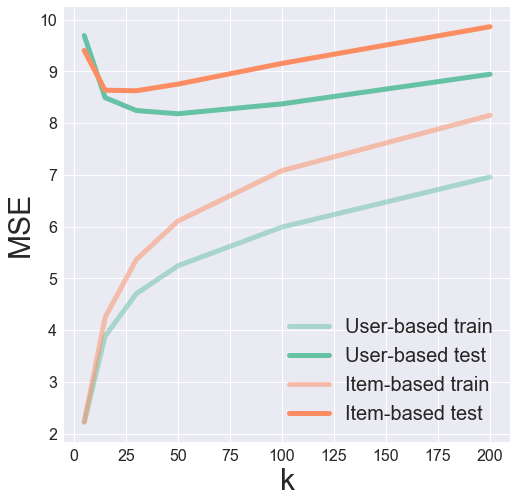

In [32]:
#plot the estimates
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

Making predictions for users given a movie item.

In [33]:
def top_k_movies(similarity, movie_idx, k=6):
    return [np.argsort(similarity[movie_idx,:])[:-k-1:-1]]

In [44]:

movies  = top_k_movies(item_similarity, 239, 6)
data.loc[movies[0]-1, 'name']

238          Dumb & Dumber 
310           American Pie 
130     Addams Family, The 
405    Karate Kid III, The 
220            Stand by Me 
178     Lady and the Tramp 
Name: name, dtype: object